In [42]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Number of classes to load from digits dataset
nn = 3

X = load_iris().data #[:,2:]
y = load_iris()['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=101)

In [55]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

nn = 3

X = load_iris().data
y = load_iris()['target']

# Data preprocessing using standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction using PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=60, train_size=90, random_state=101)

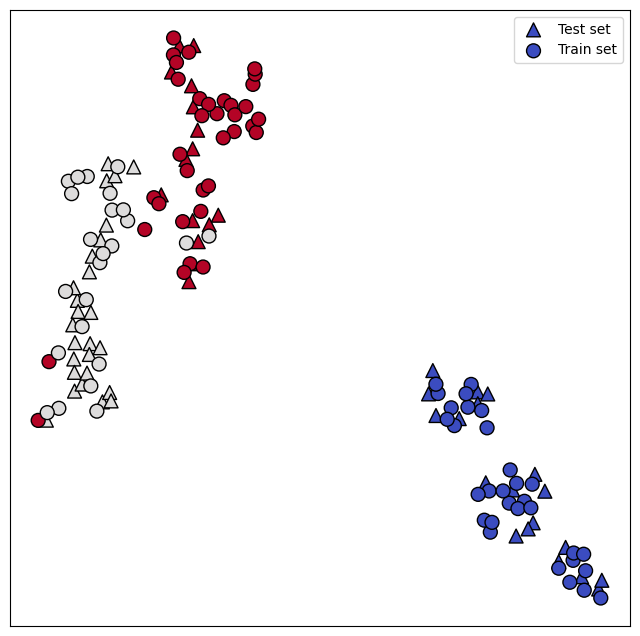

In [60]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Load data
X = load_iris().data
y = load_iris()['target']

# Data preprocessing using standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=60, train_size=90, random_state=101)

# Set up plot figures
fig, ax = plt.subplots(figsize=(8, 8))

# Define colormap for plotting
nn = 3  # Number of classes
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plotting
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=100, label='Test set')
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=100, label='Train set')

ax.set_xticks([])
ax.set_yticks([])
ax.legend()

plt.show()


In [65]:
from qsvm import *

gamma = 0.1
params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 1,
    "kernel": "rbf",
    "optimizer": "SA",
    "vis" : 0
}

# Initialize and train the classifier
sa_one_vs_rest = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
sa_one_vs_rest.solve(X_train, y_train)

# Evaluate the classifier
sa_accuracy = sa_one_vs_rest.evaluate(X_test, y_test)
print(f"Test Accuracy: {sa_accuracy*100:.2f}%")

Training classifier 0...
solving...
K,N 2 90
self.intercept -1.6255766726353336
Training classifier 1...
solving...
K,N 2 90
self.intercept 0.05632025667908888
Training classifier 2...
solving...
K,N 2 90
self.intercept -0.9035908593613932
pred result [0 0 0 2 1 2 1 1 2 0 2 0 0 2 2 1 1 1 0 1 1 0 1 1 1 1 1 2 0 0 2 1 2 1 2 1 1
 1 1 2 0 0 0 1 1 0 2 1 0 1 1 0 2 0 1 2 1 0 0 1]
Test Accuracy: 98.33%


In [74]:
# import pandas as pd
# import matplotlib.pyplot as plt

# import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from smo_svm import smo_SVM, smo_OneVsAllClassifier


# Load and process dataset
iris_dataset = load_iris()

x_train, x_test, y_train, y_test = train_test_split(
    iris_dataset.data,
    iris_dataset.target,
    shuffle=True,
    test_size=0.3,
    stratify=iris_dataset.target
)

print(f'Dataset split summary:')
print(f'Training set size: {x_train.shape[0]}')
print(f'Testing set size: {x_test.shape[0]}')

# # Visualize training dataset
# iris_df = pd.DataFrame(x_train, columns=iris_dataset.feature_names)
# iris_df['species'] = iris_dataset.target_names[y_train.reshape(-1,1)]
# sns.pairplot(iris_df, hue=iris_df.columns[-1])
# plt.show()

# Train Multiclass SVM

solver = smo_OneVsAllClassifier(
    solver=smo_SVM,
    num_classes=len(iris_dataset.target_names),
    c=1.0,
    kkt_thr=1e-3,
    max_iter=1e3,
    kernel_type='rbf',
    gamma_rbf=1.
)

solver.fit(x_train, y_train)

# Predict
y_pred = solver.predict(x_test)

# Performance analysis
print(classification_report(y_test, y_pred, target_names=iris_dataset.target_names))

Dataset split summary:
Training set size: 105
Testing set size: 45
SVM training using SMO algorithm - START
Training summary: 783 iterations, 30 supprts vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 917 iterations, 36 supprts vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 738 iterations, 38 supprts vectors
SVM training using SMO algorithm - DONE!
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

gamma = 0.05
# Initialize the classical SVM classifier
svm_classifier = SVC(kernel='rbf', gamma=gamma)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"Classical SVM Test Accuracy: {svm_accuracy*100:.2f}%")

Classical SVM Test Accuracy: 98.33%


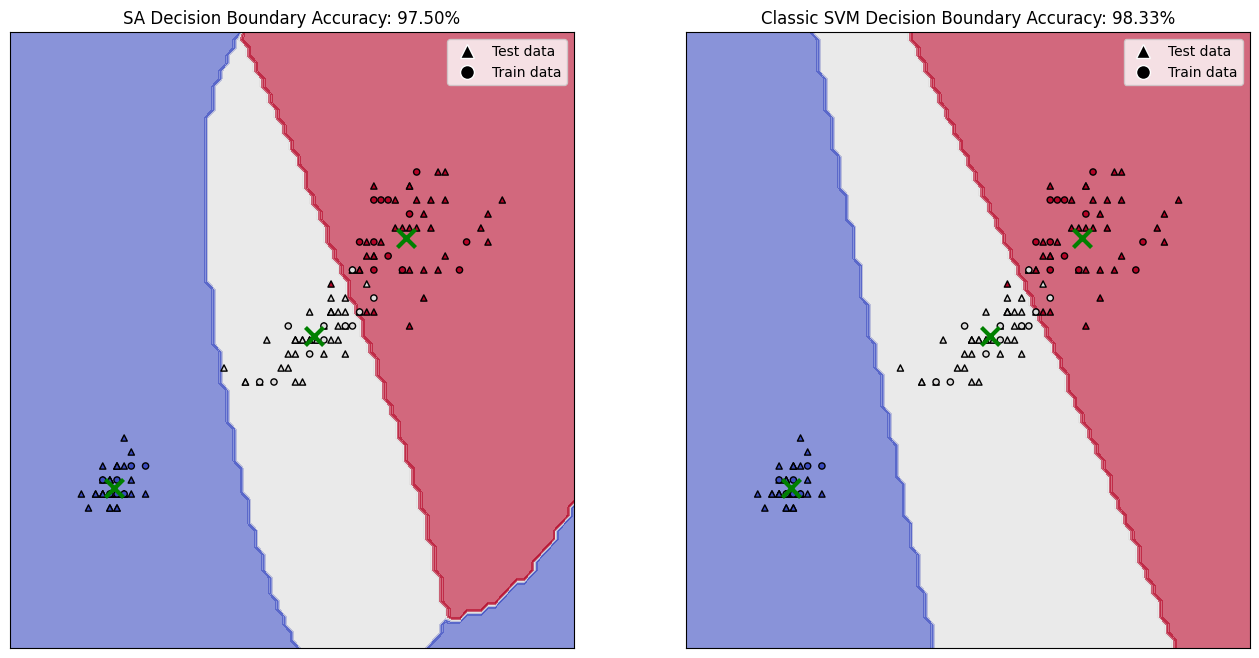

In [31]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))

# Create meshgrid
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)
# cm = plt.cm.coolwarm
# cm = plt.cm.Paired

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, sa_one_vs_rest, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"SA Decision Boundary Accuracy: {sa_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, svm_classifier, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"Classic SVM Decision Boundary Accuracy: {svm_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_SA_Classic.png",  bbox_inches='tight', dpi = 300)

plt.show()

Confusion matrix:
[[43  0  0]
 [ 0 38  1]
 [ 0  1 37]]


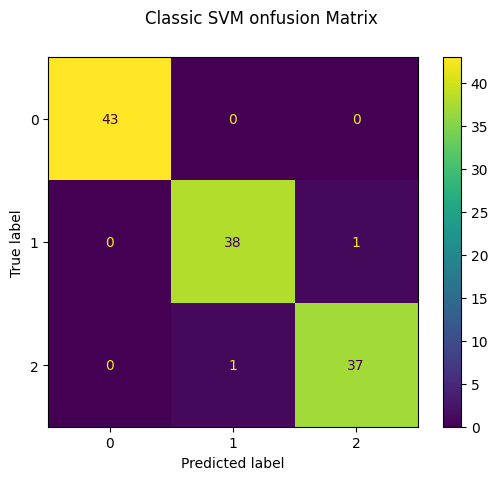

In [32]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
disp.figure_.suptitle("Classic SVM onfusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.savefig("results\iris_classic_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

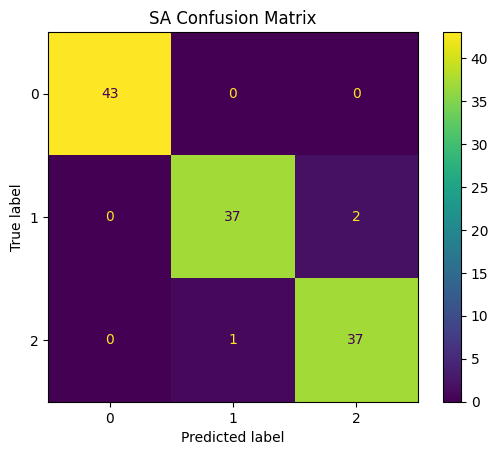

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = sa_one_vs_rest.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("SA Confusion Matrix")

plt.savefig("results\iris_sa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [37]:
from qsvm import *

gamma = 0.2
params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 1,
    "kernel": "rbf",
    "optimizer": "QA",
    "vis" : 0
}

# Initialize and train the classifier
qa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
qa_OvR.solve(X_train, y_train)

# Evaluate the classifier
qa_accuracy = qa_OvR.evaluate(X_test, y_test)
print(f"Test Accuracy: {qa_accuracy*100:.2f}%")

Training classifier 0...
solving...
K,N 2 30
self.intercept 1.8195482424880987
Training classifier 1...
solving...
K,N 2 30
self.intercept -4.6777728728177355
Training classifier 2...
solving...
K,N 2 30
self.intercept -1.3707612969316296
pred result [0 0 0 2 1 1 1 1 2 0 2 0 0 2 1 1 1 1 0 2 1 0 1 1 1 1 1 2 0 0 2 1 2 1 2 1 1
 1 1 2 0 0 0 1 1 0 2 1 0 1 1 0 2 0 1 2 1 0 0 1 0 1 2 2 1 0 1 0 2 2 1 2 1 2
 0 0 0 1 0 0 0 2 0 0 1 1 0 0 2 2 2 0 1 2 0 0 1 2 0 1 0 1 2 0 2 1 1 2 0 2 0
 1 1 0 1 0 2 1 2 0]
Test Accuracy: 94.17%


self.intercept 24.890512169399862
self.intercept -4.402748612750732
self.intercept 10.737196288849036


C:\Users\happy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook.py:1087: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


pred result [0 0 0 2 1 1 1 1 1 0 2 0 0 2 1 1 1 1 0 2 1 0 1 1 1 1 1 2 0 0 2 1 2 1 2 1 1
 1 1 2 0 0 0 1 1 0 2 1 0 0 1 0 2 0 1 2 1 0 0 1 0 1 2 2 1 0 1 0 2 2 1 2 1 2
 0 0 0 1 0 0 0 2 0 0 1 1 0 0 2 2 2 0 1 2 0 0 1 2 0 1 0 1 2 0 2 1 1 2 0 2 0
 1 1 0 1 0 2 1 2 0]
Test Accuracy: 92.50%


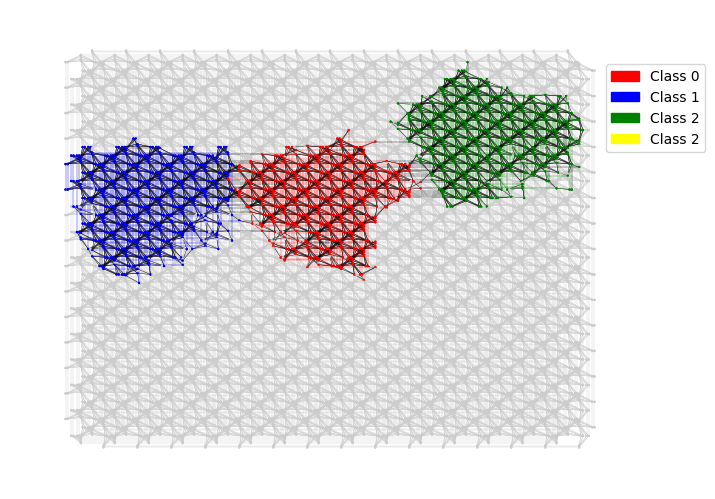

In [34]:
from qsvm import *

gamma = 0.2
params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 1,
    "kernel": "rbf",
    "optimizer": "MTQA",
    "vis": 1
}

# Initialize and train the classifier
mtqa_OvR = MTQA_OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
mtqa_OvR.solve(X_train, y_train)

# Evaluate the classifier
mtqa_accuracy = mtqa_OvR.evaluate(X_test, y_test)
print(f"Test Accuracy: {mtqa_accuracy*100:.2f}%")

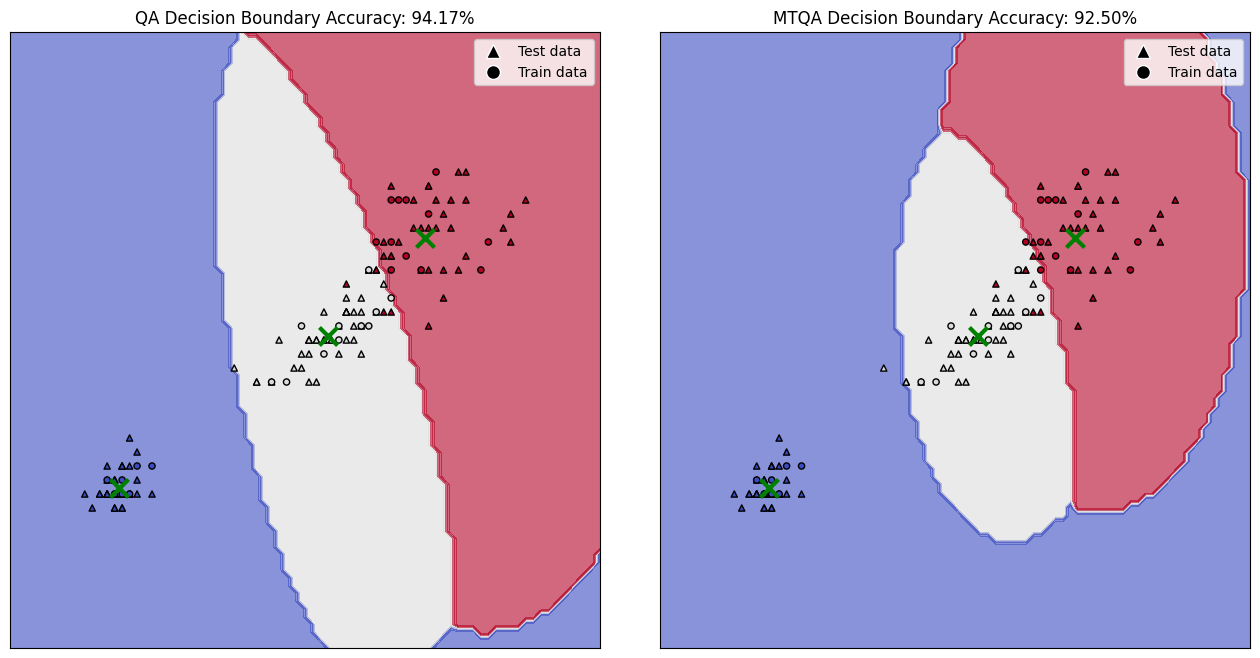

In [38]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

# Create meshgrid
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, qa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"QA Decision Boundary Accuracy: {qa_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, mtqa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"MTQA Decision Boundary Accuracy: {mtqa_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_QA_MTQA.png",  bbox_inches='tight', dpi = 300)

plt.show()

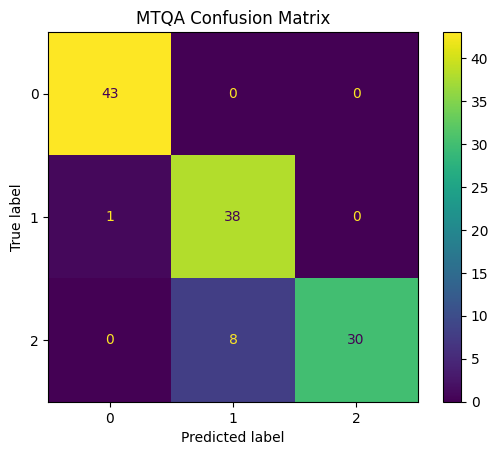

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = mtqa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("MTQA Confusion Matrix")

plt.savefig("results\iris_mtqa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()


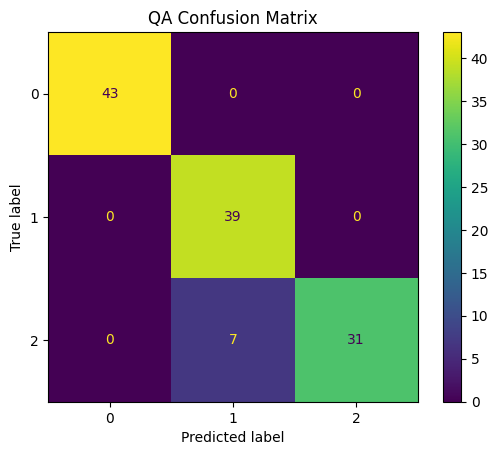

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = qa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("QA Confusion Matrix")

plt.savefig("results\digit_0_3_qa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()
